In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
plt.style.use('fivethirtyeight') 

import pandas as pd
import os
import sys
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, auc, f1_score, explained_variance_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src/visualization/')
import visualize as vis

df = pd.read_csv('../data/interim/Third_order_clean_confidential.csv').drop(columns=['Unnamed: 0'])
contact_codes = pd.read_csv('../data/processed/contact_codes_at_application.csv').drop(columns=['Unnamed: 0'])

shap.initjs()

%matplotlib inline

Merge new and old SAT scores, and drop the SATWriting category.


List of columns worth 1-hot-encoding:
* Application_Type
* Application_Format
* Region
* Dependent/Independent
* Gender
* Legacy

In [10]:
X = df.drop(columns=['State_grants','Pell_grant', 'HSCEEB', 'ADMT_DEC_CODE',
                     'Ccbnm_long','Ccbnm_lat','Dist_to_Ccbnm','Home_Long',
                    'Home_Lat','Number_of_campus_visits','TotalWeight',
                     'Fresh_enroll', 'Year_of_entry','FT_Tuition_Fees','HS_Numeric_rank','WeightatAcpt',
                    'Selected_for_verification','Ccbnm_for_dist','College_chosen_by_non-matrics',
                     'DOB','SAT_combined','SAT_reading','SAT_writing','SAT_math','NEWSATVerbal',
                     'NEWSATVerbalMath','NEWSATMath','Street1_perm_res','Zip_perm_res','Major',
                     'Test_Optional','Cond_Admit','Dependent_Independent_status','Verification_Completed',
                     'Initial_inquiry_source','First_generation','Status','Indicated_intent_to_apply_for_FA',
                     'Admission_status','County_perm_res','City_perm_res','State_perm_res','International_student',
                     'HD_Academic_Rating','FatherEd','MotherEd','Application_Type','Application_format',
                     'COA','RESD','COMM','Gender'
                    ])

for col in X.columns.values:
    for word in ['FM','Wages','Cash','worth','investment','budget','date','FAFSA','coa','Ints',
                'cost','income']:
        if word.lower() in col.lower():
            X = X.drop(columns=col)
            break
            
col_names = ['Region_'+region for region in ['A','B','C','D','E','F','G','H','I','J','K','Z']]
X[col_names] = pd.get_dummies(X['Region'])[['A','B','C','D','E','F','G','H','I','J','K','Z']]
X = X.drop(columns='Region')

# col_names = ['Male','Female','Non-Binary']
# X[col_names] = pd.get_dummies(X['Gender'])
# X = X.drop(columns='Gender')

# for col in contact_codes.columns.values:
#     if col!='Unique_student_ID':
#         X[col] = X['Unique_student_ID'].map(contact_codes['Unique_student_ID'],contact_codes[col])

X = pd.merge(X,contact_codes,how='left',on='Unique_student_ID')

X = X.drop(columns='Unique_student_ID').drop_duplicates()

Y = X['Enrolled'].fillna(-999)

X = X.drop(columns="Enrolled").fillna(-999)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [11]:
# scaling the data before PCA
from sklearn.preprocessing import scale
scaled = pd.DataFrame(scale(X),columns=X.columns.values)

# implementing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5).fit(scaled)
pca_samples = pca.transform(scaled)

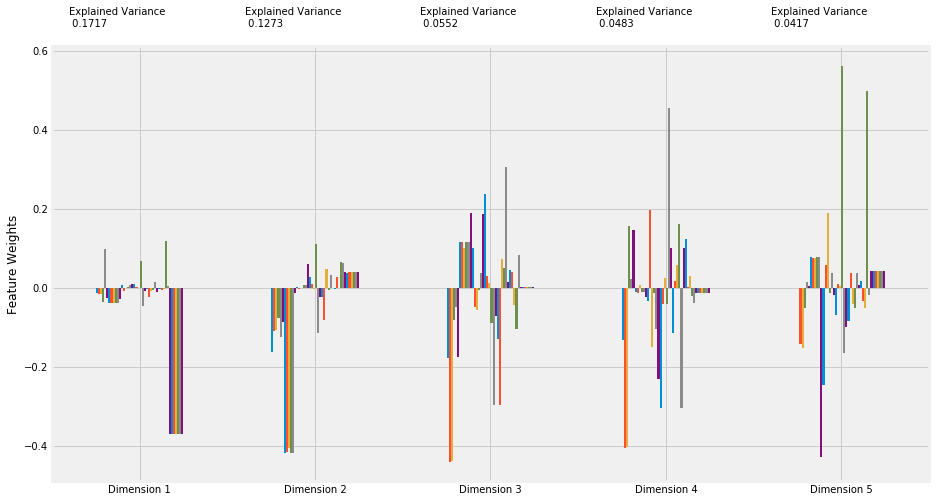

In [12]:
# Dimension indexing
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = scaled.keys()) 
components.index = dimensions

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
variance_ratios.index = dimensions

# Create a bar plot visualization
fig, ax = plt.subplots(figsize = (14,8))

# Plot the feature weights as a function of the components
components.plot(ax = ax, kind = 'bar')
ax.set_ylabel("Feature Weights") 
ax.set_xticklabels(dimensions, rotation=0)

# Display the explained variance ratios# 
for i, ev in enumerate(pca.explained_variance_ratio_): 
    ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))
ax.get_legend().remove()
    
pca_results = pd.concat([variance_ratios, components], axis = 1)

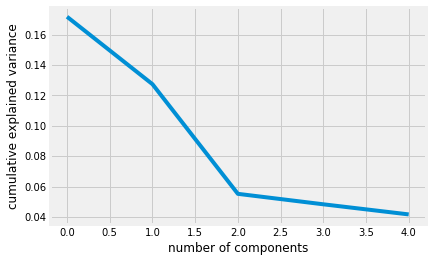

In [13]:
vis.plot_explained_variance_ratio(pca);

# Applicants in bottom left group: 15610
# Enrolled in bottom left group: 1561 

# Applicants in bottom right group: 2055
# Enrolled in bottom right group: 159 

# Applicants in upper left group: 11264
# Enrolled in upper left group: 992 

# Applicants in upper right group: 1647
# Enrolled in upper right group: 116 



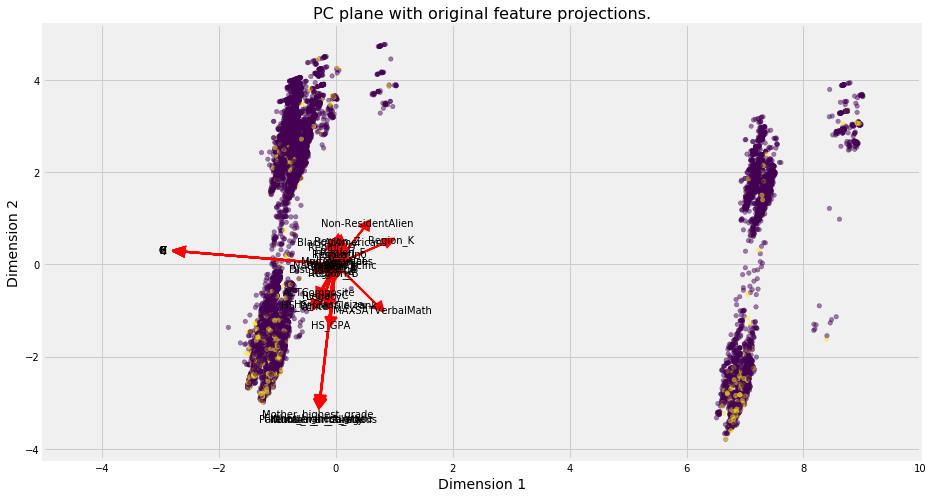

In [17]:
pca = PCA(n_components=3).fit(scaled)
reduced_data = pca.transform(scaled)

pca_samples = pca.transform(scaled)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

red_enrolled = pd.merge(reduced_data,Y,how='left',left_index=True,right_index=True).drop_duplicates()

fig, ax = plt.subplots(figsize = (14,8))

# scatterplot of the reduced data 
ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], c=Y, s=20, alpha=0.5)

feature_vectors = pca.components_.T

# using scaling factors to make the arrows
arrow_size, text_pos = 7.0, 8.0,

# projections of the original features
for i, v in enumerate(feature_vectors):
    ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
    ax.text(v[0]*text_pos, v[1]*text_pos, X.columns[i], color='black', ha='center', va='center', fontsize=10)

ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)
ax.set_title("PC plane with original feature projections.", fontsize=16);

plt.xlim(-5,10);

print("# Applicants in bottom left group: %d" % len(red_enrolled.where((red_enrolled['Dimension 1']<2) & (red_enrolled['Dimension 2']<0)).dropna()))
print("# Enrolled in bottom left group: %d \n" % len(red_enrolled.where((red_enrolled['Dimension 1']<2) & (red_enrolled['Dimension 2']<0) & (red_enrolled['Enrolled'])).dropna()))

print("# Applicants in bottom right group: %d" % len(red_enrolled.where((red_enrolled['Dimension 1']>2) & (red_enrolled['Dimension 2']<0)).dropna()))
print("# Enrolled in bottom right group: %d \n" % len(red_enrolled.where((red_enrolled['Dimension 1']>2) & (red_enrolled['Dimension 2']<0) & (red_enrolled['Enrolled'])).dropna()))

print("# Applicants in upper left group: %d" % len(red_enrolled.where((red_enrolled['Dimension 1']<2) & (red_enrolled['Dimension 2']>0)).dropna()))
print("# Enrolled in upper left group: %d \n" % len(red_enrolled.where((red_enrolled['Dimension 1']<2) & (red_enrolled['Dimension 2']>0) & (red_enrolled['Enrolled'])).dropna()))

print("# Applicants in upper right group: %d" % len(red_enrolled.where((red_enrolled['Dimension 1']>2) & (red_enrolled['Dimension 2']>0)).dropna()))
print("# Enrolled in upper right group: %d \n" % len(red_enrolled.where((red_enrolled['Dimension 1']>2) & (red_enrolled['Dimension 2']>0) & (red_enrolled['Enrolled'])).dropna()))

## Sklearn Logistic Regression Model

In [19]:
idx = X_test.index

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

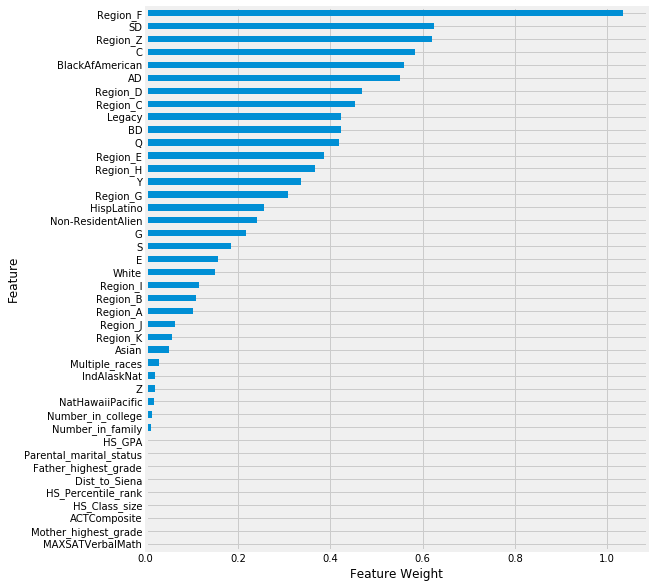

In [21]:
feature_importance = pd.Series(model.coef_[0])
feature_importance.index = X.columns.values

feature_importance = (abs(feature_importance)).sort_values()

f, axes = plt.subplots(figsize=(8,10))
feature_importance.plot(kind='barh');
plt.xlabel("Feature Weight")
plt.ylabel("Feature");

Distribution of Likelihood of Attendance

In [22]:
likelihood_of_attendance = y_pred[:,1] # first column is prob 0, second column is prob 1

Make DataFrame of Likelihood v. Actual

In [23]:
likelihood = pd.DataFrame([list(likelihood_of_attendance),y_test]).T.rename(columns={0:"Likelihood of Enrollment",1:"Enrolled"})

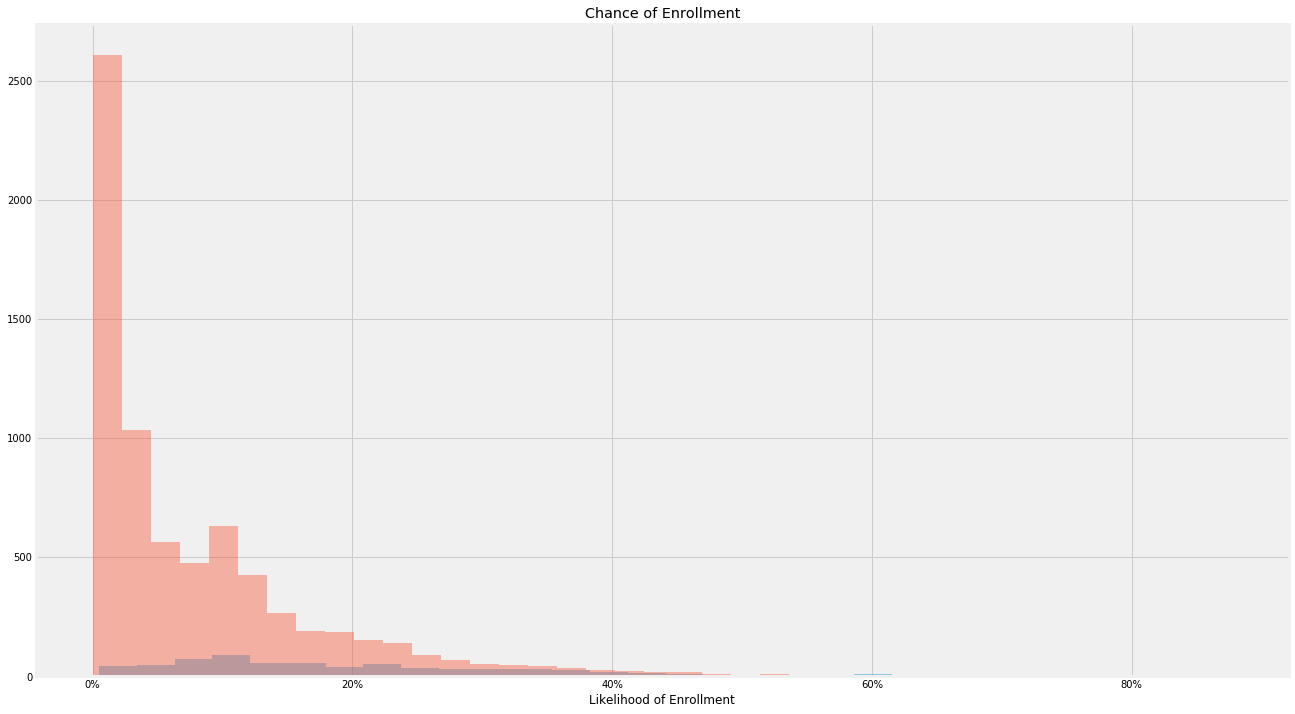

In [24]:
f, axes = plt.subplots(figsize=(20,12))
sns.distplot(likelihood['Likelihood of Enrollment'][likelihood['Enrolled']],kde=False,bins=30)
sns.distplot(likelihood['Likelihood of Enrollment'][likelihood['Enrolled']==False],kde=False,bins=30)

plt.title("Chance of Enrollment");
vals = axes.get_xticks()
axes.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);

Is this a good indicator for enrollment??? What about being a good indicator for students to *NOT* pursue??

In [25]:
# Look at chance of enrollment > 20%, and likelihood < 5 %
unlikely = likelihood.where(likelihood['Likelihood of Enrollment']<=0.05).dropna()
more_likely = likelihood.where(likelihood['Likelihood of Enrollment']>=0.2).dropna()

In [26]:
unlikely.describe()

,Likelihood of Enrollment,Enrolled
count,3874.00000,3874
unique,3874.00000,2
top,0.00088,False
freq,1.00000,3804


In [28]:
more_likely.describe() # 

,Likelihood of Enrollment,Enrolled
count,1069.000000,1069
unique,1069.000000,2
top,0.235813,False
freq,1.000000,760


## XGBoost Logistic Regression Model

In [30]:
best_params = {'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 11,
 'missing': -999,
 'n_estimators': 500,
 'nthread': 4,
 'seed': 42,
 'silent': 1,
 'subsample': 0.8,
 'objective': 'reg:logistic'}  # found from GridSearchCV 

modelX = xgb.XGBRegressor(**best_params)
modelX.fit(X_train, y_train)
y_pred = modelX.predict(X_test)

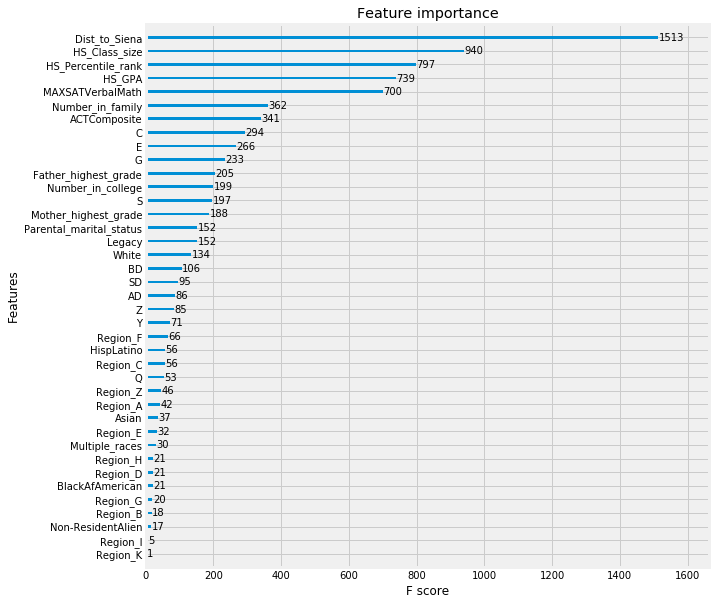

In [31]:
vis.my_plot_importance(modelX,figsize=(9,10))

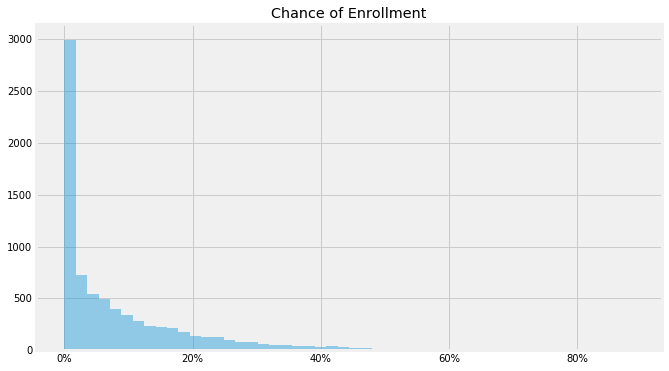

In [32]:
f, axes = plt.subplots(figsize=(10,6))
sns.distplot(y_pred,kde=False)
plt.title("Chance of Enrollment");
vals = axes.get_xticks()
axes.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);

In [33]:
likelihood = pd.DataFrame([y_pred,y_test]).T.rename(columns={0:"Likelihood of Enrollment",1:"Enrolled"})

In [34]:
unlikely = likelihood.where(likelihood['Likelihood of Enrollment']<=0.05).dropna()
more_likely = likelihood.where(likelihood['Likelihood of Enrollment']>=0.2).dropna()

In [35]:
unlikely.describe()

,Likelihood of Enrollment,Enrolled
count,4170.000000,4170
unique,4162.000000,2
top,0.000715,False
freq,2.000000,4098


In [37]:
more_likely.describe() # 

,Likelihood of Enrollment,Enrolled
count,1162.000000,1162
unique,1162.000000,2
top,0.236965,False
freq,1.000000,825


### Deeper Look at XGBoost Model

In [39]:
explainer = shap.TreeExplainer(modelX)
shap_values = explainer.shap_values(X)

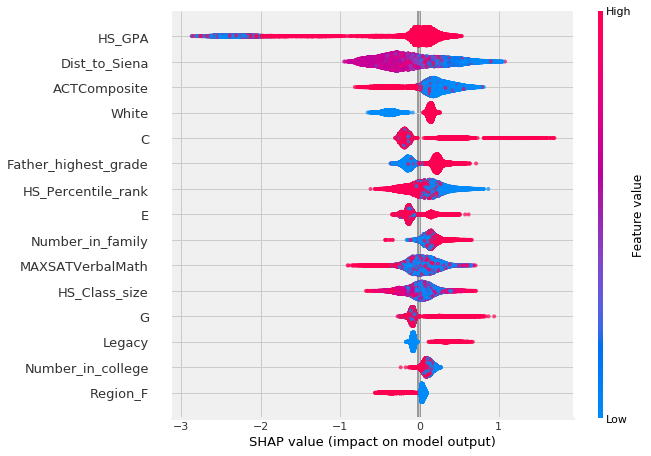

In [40]:
sum_plot = shap.summary_plot(shap_values, X, max_display=15, show=True, alpha=0.7,
                  plot_type='dot')

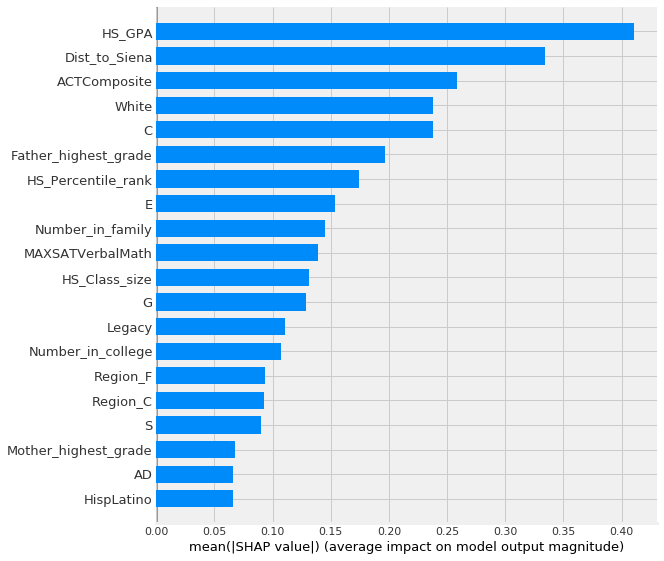

In [41]:
shap.summary_plot(shap_values, X, max_display=20, show=True,
                  plot_type='bar')